In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

2024-06-25 17:20:28.694203: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-25 17:20:28.694342: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-25 17:20:28.953960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Data augmentation parameters
data_gen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.3,
    fill_mode='nearest',
    rescale=1./255  # Normalize pixel values
)

In [3]:
!pip install split-folders

!splitfolders --ratio 0.8 0.1 0.1 -- /kaggle/input/scaled-mulberry-leaf-dataset/Smaller

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Copying files: 1091 files [00:09, 110.29 files/s]


In [4]:
# Define the model
model = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),    
    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    # Flatten layer
    Flatten(),
    # Dense layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Output layer with 3 classes
])



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,347 (42.61 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Data generators
train_generator = data_gen.flow_from_directory(
    '/kaggle/working/output/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)


Found 872 images belonging to 3 classes.


In [7]:
validation_generator = data_gen.flow_from_directory(
    '/kaggle/working/output/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)


Found 108 images belonging to 3 classes.


In [8]:
# Train the model
history = model.fit(
    train_generator,
    epochs=60,
    validation_data=validation_generator,
)


Epoch 1/60


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 2/28 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4922 - loss: 1.9994 - precision: 0.2812 - recall: 0.1406         

I0000 00:00:1719336093.274878      79 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719336093.294913      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.6288 - loss: 1.2798 - precision: 0.6565 - recall: 0.4836

W0000 00:00:1719336110.063662      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


28/28 ━━━━━━━━━━━━━━━━━━━━ 36s 714ms/step - accuracy: 0.6341 - loss: 1.2484 - precision: 0.6625 - recall: 0.4933 - val_accuracy: 0.7778 - val_loss: 0.4958 - val_precision: 0.7905 - val_recall: 0.7685
Epoch 2/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 469ms/step - accuracy: 0.7821 - loss: 0.5221 - precision: 0.8001 - recall: 0.7581 - val_accuracy: 0.8241 - val_loss: 0.4005 - val_precision: 0.8224 - val_recall: 0.8148
Epoch 3/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 463ms/step - accuracy: 0.8187 - loss: 0.4690 - precision: 0.8212 - recall: 0.8146 - val_accuracy: 0.8333 - val_loss: 0.3794 - val_precision: 0.8333 - val_recall: 0.8333
Epoch 4/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 460ms/step - accuracy: 0.8433 - loss: 0.3701 - precision: 0.8467 - recall: 0.8430 - val_accuracy: 0.8796 - val_loss: 0.3578 - val_precision: 0.9029 - val_recall: 0.8611
Epoch 5/60
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 465ms/step - accuracy: 0.8363 - loss: 0.4155 - precision: 0.8580 - recall: 0.8223 - val_accuracy: 0.8426 - val_loss: 0.3679 -

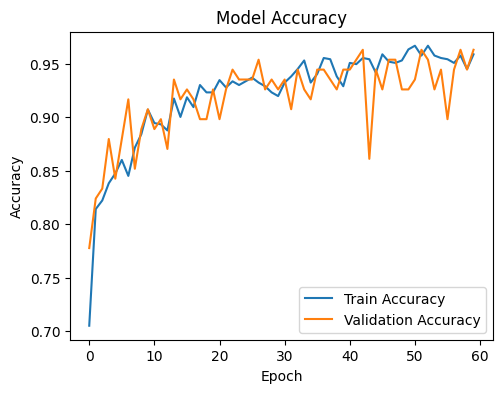

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

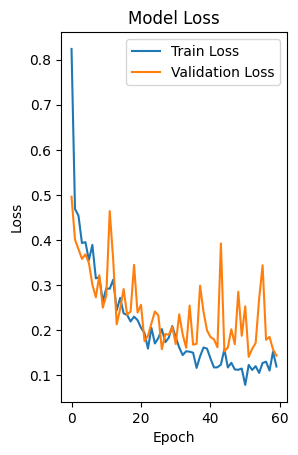

In [10]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
# Evaluation on test set
test_data_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_data_gen.flow_from_directory(
    '/kaggle/working/output/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 111 images belonging to 3 classes.


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step 

W0000 00:00:1719337113.146701      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 733ms/step


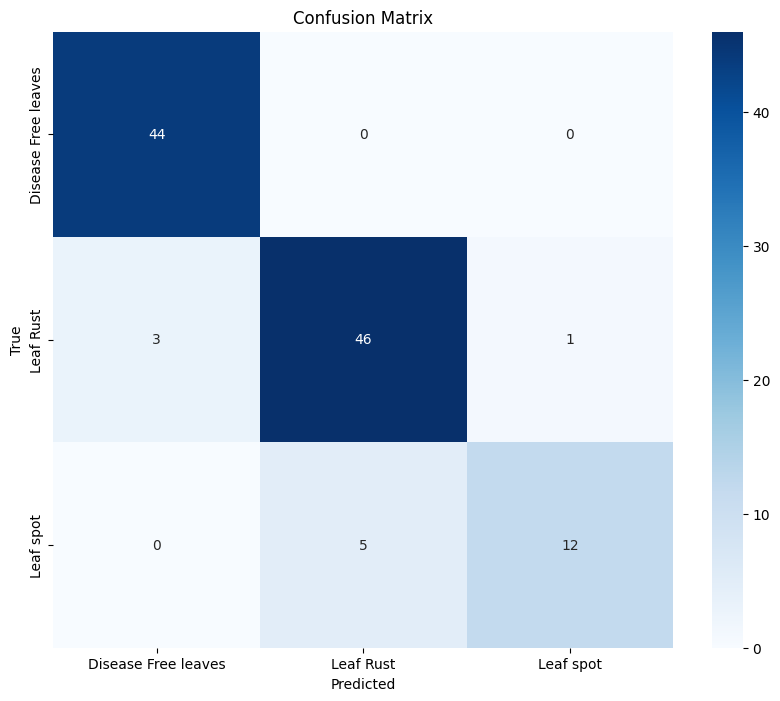

Classification Report
                     precision    recall  f1-score   support

Disease Free leaves       0.94      1.00      0.97        44
          Leaf Rust       0.90      0.92      0.91        50
          Leaf spot       0.92      0.71      0.80        17

           accuracy                           0.92       111
          macro avg       0.92      0.88      0.89       111
       weighted avg       0.92      0.92      0.92       111

Precision: 0.9188
Recall: 0.9189
F1 Score: 0.9162


In [12]:
# Predict the classes
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report')
print(report)

# Precision, Recall, F1 Score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

In [13]:
model.evaluate(test_generator)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - accuracy: 0.9457 - loss: 0.1264 - precision: 0.9457 - recall: 0.9457


[0.21243757009506226,
 0.9189189076423645,
 0.9189189076423645,
 0.9189189076423645]

In [14]:
model.save("Custom_layer.h5")

In [15]:
model.save("Custom_layer.keras")